# CEE 690, Lecture 19 Code Examples

This course will make use of notebook style coding.  Notebooks are incredibly useful tools both for teaching and for disseminating data anlysis.

This is a set of codes to revisist penalized regression, statistical testing, and false discovery rates.

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

This section provides some initialization commands, which can simply be copied for assignments.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# We need to import key libraries that we're going to use.  
# For now this is just numpy, which is our linear algebra library
import numpy as np

Setting the random seed for code reproducibility.

In [2]:
# to make this notebook's output stable across runs, we are going to see the random seed
np.random.seed(42)

Note that we have to reset the random seed _every_ time we run an algorithm if we want the same results!

We also want to set up a plotting environment and make it look pretty.  For those of you familiar with matlab, we will be using matplotlib which is fairly close in syntax and feel.  It's not too far off from R either.

In [3]:
# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline 
# This command figures show up in the notebook.  It's a "magic" command...
# Typically, this now happens by default so it is often an unnecessary command, but is good for standardization.
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

These commands will help us save figures; not going to go through them so much.

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "18"

In [5]:
# makes the directory if it doesn't exist.
import os
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory didn\'t exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.') 

Figure directory exists.


In [6]:
# a simple defined helper function.
def savepdf(fig,name):
    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf',transparent=True)

# Time Series

In [7]:
import pandas as pd

In [8]:
data=pd.read_csv('./data/AQ_Mortality/train.csv')
# show the first 5 rows
data=data.dropna()
data[:5]

,Id,region,date,mortality_rate,O3,PM10,PM25,NO2,T2M
6570,6571,E12000001,2009-01-01,2.213,22.833,9.614,4.078,7.882,273.262
6571,6572,E12000001,2009-01-02,2.446,26.065,8.584,3.710,11.312,273.857
6572,6573,E12000001,2009-01-03,2.174,35.166,14.295,2.911,6.419,272.466
6573,6574,E12000001,2009-01-04,2.563,31.671,16.309,5.792,4.946,274.597
6574,6575,E12000001,2009-01-05,2.679,31.801,11.041,4.527,8.263,273.160


This is a dataset that gives air quality measurements (ozone, pm 10, pm 2.5, nitric oxide) and temperature in kelvins and gives the accompanying mortality rate (as measured through the national health system in England) on that data. This dataset contains multiple regions, so we're going to limit ourself to a single region to make this a standard time series.

In [9]:
regions=np.unique(data['region'].values)
single_region_data=data[data.region==regions[0]]
single_region_data[:5]

,Id,region,date,mortality_rate,O3,PM10,PM25,NO2,T2M
6570,6571,E12000001,2009-01-01,2.213,22.833,9.614,4.078,7.882,273.262
6571,6572,E12000001,2009-01-02,2.446,26.065,8.584,3.710,11.312,273.857
6572,6573,E12000001,2009-01-03,2.174,35.166,14.295,2.911,6.419,272.466
6573,6574,E12000001,2009-01-04,2.563,31.671,16.309,5.792,4.946,274.597
6574,6575,E12000001,2009-01-05,2.679,31.801,11.041,4.527,8.263,273.160


Instead of using a data frame, we're going to use a standard matrix here.  We'll do this by converting to a numpy array.

In [10]:
mortality_rates=single_region_data.mortality_rate.values.astype('float64')
covariates=single_region_data.values[:,4:].astype('float64')
dates=single_region_data.date.values

In [54]:
mortality_rates

array([2.213, 2.446, 2.174, ..., 1.691, 2.69 , 1.729])

Note the format of the dates...

In [11]:
dates

array(['2009-01-01', '2009-01-02', '2009-01-03', ..., '2012-12-29',
       '2012-12-30', '2012-12-31'], dtype=object)

what does $y$ (our mortality rates) look like as a time series?

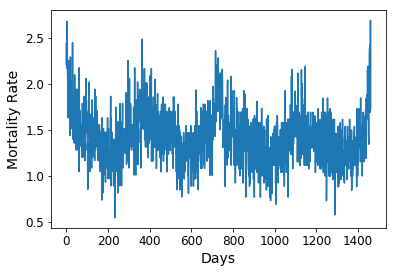

In [12]:
fig=plt.figure()
plt.plot(mortality_rates)
plt.xlabel('Days')
plt.ylabel('Mortality Rate')
plt.show()
savepdf(fig,'full_series')

Can see the trends better by showing in years.

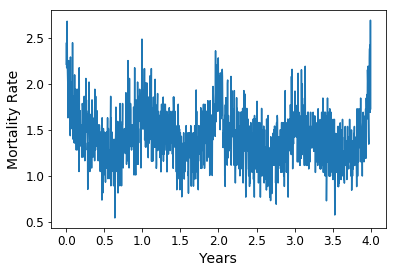

In [13]:
fig=plt.figure()
plt.plot(np.arange(0,1/365*len(mortality_rates),1/365),mortality_rates)
plt.xlabel('Years')
plt.ylabel('Mortality Rate')
plt.show()
savepdf(fig,'full_series_years')

## Forecasting

##### First we just set up the problem _without_ cross-validation to see the forecasting setup

Can we predict from recent history?

In [14]:
from sklearn import linear_model
from sklearn import metrics

Let's vary over the number of 'lags' in the data

In [15]:
n_lag=1

This means that we take the measurements from the day before to predict the current values.  We're going to start by only predicting the current morality rates from only the older mortality rates.

In [16]:
# Construct our new 'X' matrix
n_max=len(mortality_rates)
X=np.zeros([n_max-n_lag,n_lag])
for i in range(0,n_max-1):
    X[i]=mortality_rates[i:i+n_lag]
y=mortality_rates[n_lag:]

In [56]:
print(X.shape)
print(y.shape)

(1447, 14)
(1447,)


Train a model to see how well this works:

In [18]:
lin_reg=linear_model.LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Built in $R^2$ coefficient, which gives us the amount of explained variance. Note that this is _training_ $R^2$, so be cautious with this value.

In [19]:
lin_reg.score(X,y)

0.14310146971360693

This means that we explain 14% of the variance, which isn't so bad.

Does adding more history give us a better forecasting?

In [59]:
lin_reg=linear_model.LinearRegression()
max_lags=25
r2_scores=np.zeros([max_lags-1])

for n_lag in range(1,max_lags):
    # Construct our new 'X' matrix
    n_max=len(mortality_rates)
    X=np.zeros([n_max-n_lag,n_lag])
    for i in range(0,n_max-n_lag):
        X[i]=mortality_rates[i:i+n_lag]
    y=mortality_rates[n_lag:]
    lin_reg.fit(X,y)
    score=lin_reg.score(X,y)
    r2_scores[n_lag-1]=score

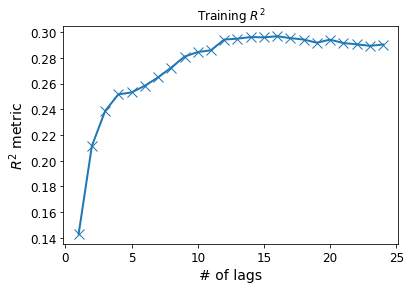

In [60]:
fig=plt.figure()
plt.plot(range(1,max_lags),r2_scores,'x-',lw=2,ms=10)
plt.xlabel('# of lags')
plt.ylabel('$R^2$ metric')
plt.title('Training $R^2$')
plt.show()

Do nonlinear models help?

In [22]:
from sklearn import neighbors

In [23]:
knn=neighbors.KNeighborsRegressor(n_neighbors=10)
knn.fit(X,y)
print('Explained R^2 on the training data is {}'.format(knn.score(X,y)))

Explained R^2 on the training data is 0.35723984304939593


Way higher! Does it hold up with cross-validation?
We'll come back to this in a second.


What about adding in the covariate information of interest?

In [24]:
from sklearn import pipeline
from sklearn import preprocessing

We'll add the AQ measurements on the current day to predict the mortality.

In [25]:
X_aug=np.concatenate([X,covariates[n_lag:]],axis=1)

In [26]:
normalizer=preprocessing.StandardScaler()
knn=neighbors.KNeighborsRegressor(n_neighbors=10)
pipe=pipeline.Pipeline([('norm',normalizer),('knn',knn)])
pipe.fit(X_aug,y)
print('Explained R^2 on the training data is {}'.format(pipe.score(X_aug,y)))

Explained R^2 on the training data is 0.3574466769175221


What happens if we use our traditional cross-validation?

In [27]:
mse=metrics.mean_squared_error(lin_reg.predict(X),y)
baseline_mse=metrics.mean_squared_error(np.mean(y).repeat(y.shape),y)
print((baseline_mse-mse)/baseline_mse)

0.29629841180765637


This doesn't seem so bad, but will be very optimistic...

## Time Series Cross-Validation

We won't worry about the lag distance at first, just different ways to split the data.

#### First approach, the wrong way :)
Just randomize everything

In [28]:
from sklearn import model_selection

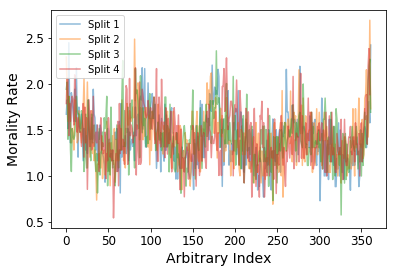

In [29]:
KFold=model_selection.KFold(n_splits=4,random_state=10,shuffle=True)
fig=plt.figure(figsize=[6,4])
for train_ndx,valid_ndx in KFold.split(X,y):
    plt.plot(y[valid_ndx],alpha=.5)
plt.xlabel('Arbitrary Index')
plt.ylabel('Morality Rate')
plt.legend(['Split 1','Split 2','Split 3','Split 4'])

There still appears to be structure here, but this is due to the ordering of the split data points. Note that due to the correlation in the data our CV-estimates will be positively biased.

In [30]:
normalizer=preprocessing.StandardScaler()
knn=neighbors.KNeighborsRegressor(n_neighbors=10)
pipe=pipeline.Pipeline([('norm',normalizer),('knn',knn)])
explained_variance=np.mean(model_selection.cross_val_score(pipe,X_aug,y,scoring='explained_variance',cv=5))
print(explained_variance)

0.19691035637428445


In the cross-validation, our performance estimate is significantly lower.  However, we still haven't gotten rid of correlation...

### What about 'online' prediction?

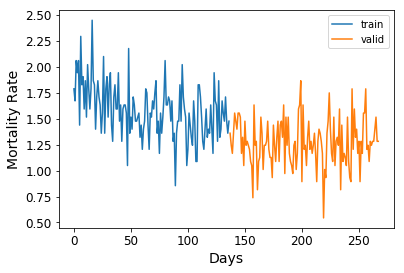

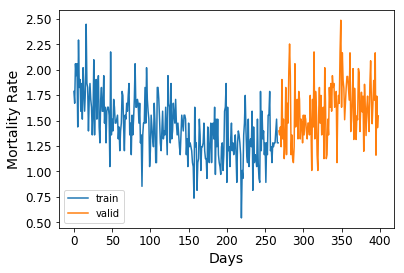

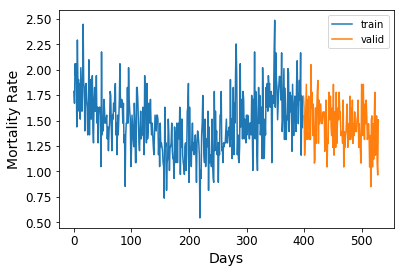

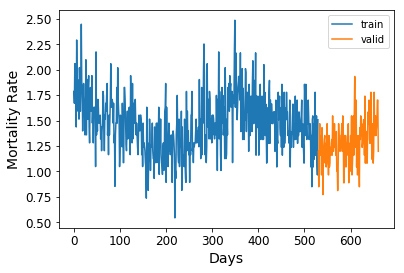

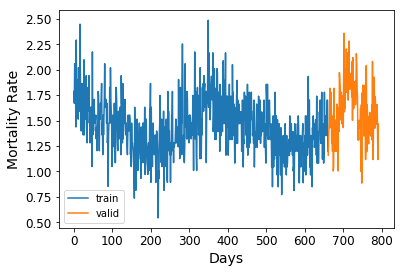

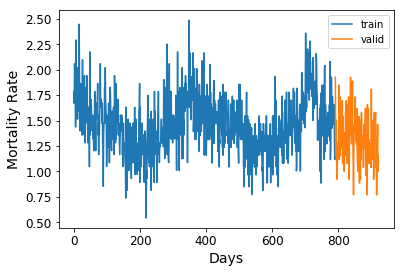

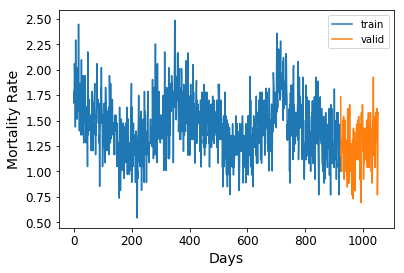

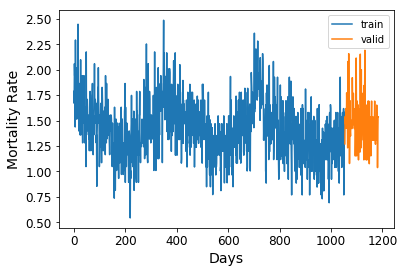

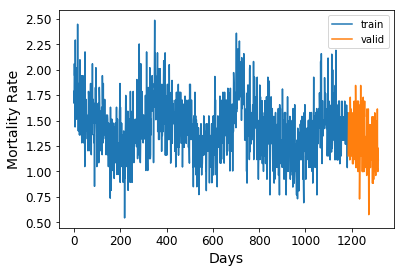

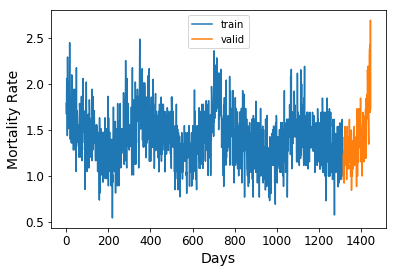

In [31]:
TSS=model_selection.TimeSeriesSplit(n_splits=10)
i=0
for train_ndx, valid_ndx in TSS.split(X,y):
    fig=plt.figure()
    plt.plot(train_ndx,y[train_ndx],label='train')
    plt.plot(valid_ndx,y[valid_ndx],label='valid')
    plt.xlabel('Days')
    plt.ylabel('Mortality Rate')
    plt.legend()
    plt.show()
    savepdf(fig,'ts_split_k_{}'.format(i))
    i+=1

In [32]:
TSS=model_selection.TimeSeriesSplit(n_splits=10)
scores=[]
for train_ndx,valid_ndx in TSS.split(X,y):
    valid_ndx_adjusted=valid_ndx
    pipe.fit(X[train_ndx],y[train_ndx])
    score=(metrics.mean_squared_error\
          (y[valid_ndx_adjusted],pipe.predict(X[valid_ndx_adjusted])))
    print(score)
    scores.append(score)
print('Average MSE of {0} with a standard error of {1}'.format(np.mean(scores),np.std(scores)/np.sqrt(KFold.n_splits)))

0.14960799022900761
0.09069250175572519
0.052042857175572506
0.0543222490076336
0.07399199374045802
0.07066830183206108
0.06114111885496183
0.06489467114503815
0.057211927480916025
0.06499715282442747
Average MSE of 0.07395707640458016 with a standard error of 0.013680979618551116


In same terms as before:

In [33]:
explained_variance=1-np.mean(scores)/metrics.mean_squared_error(np.mean(y).repeat(y.shape),y)
print(explained_variance)

0.0943915519356181


This is a marked dropoff-- however, this is largely due to some of the early blocks where we didn't have as much data.  Considering dropping the first 2 blocks.

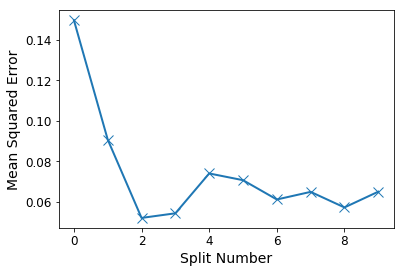

In [34]:
fig=plt.figure()
plt.plot(scores,'-x',ms=10,lw=2)
plt.xlabel('Split Number')
plt.ylabel('Mean Squared Error')
plt.show()

In [35]:
explained_variance=1-np.mean(scores[2:])/metrics.mean_squared_error(np.mean(y).repeat(y.shape),y)
print(explained_variance)

0.23580102434608785


This gives a _much_ better estimate of explained error. However, note that it is no longer comparing on the same dataset, so we must be careful in the analysis of these results.

## Comments:
I recomment the above method for the purposes of this class.  Below is for those that are interested in other options

## Cross-Validation with pseudo-independent sets

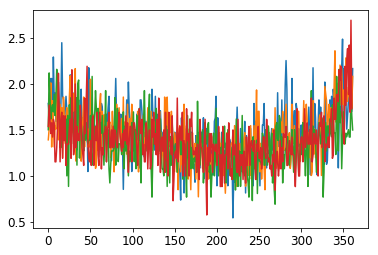

In [36]:
KFold=model_selection.KFold(n_splits=4)
for train_ndx,valid_ndx in KFold.split(X,y):
    plt.plot(y[valid_ndx])

Note that because this is a 4-year dataset, the yearly structure pops out instantly.

Visualize with trimming

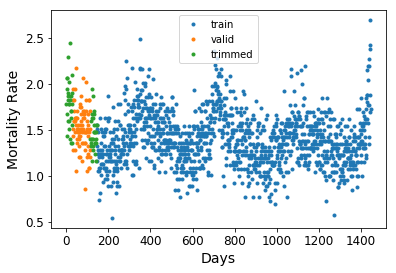

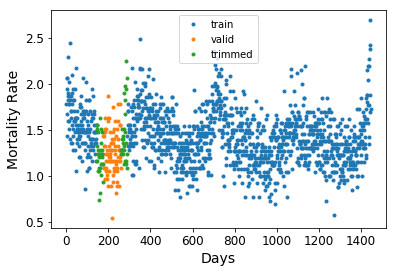

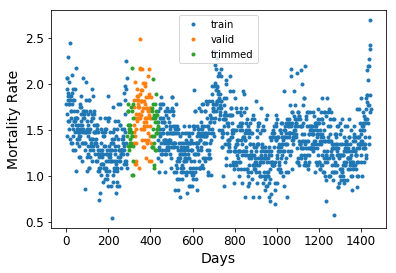

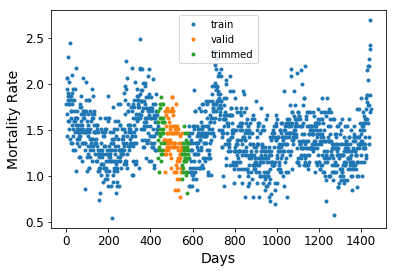

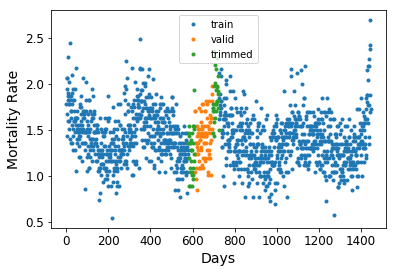

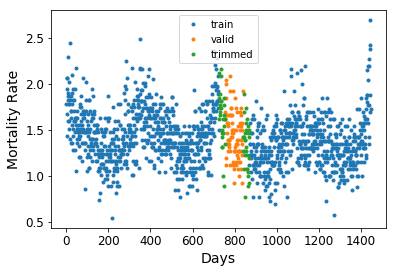

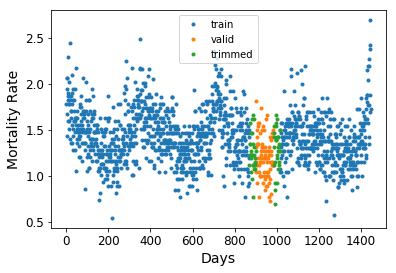

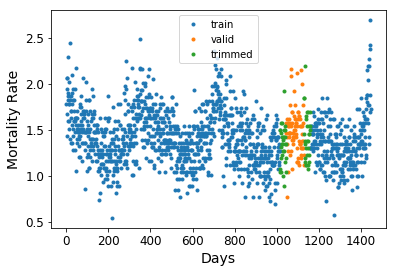

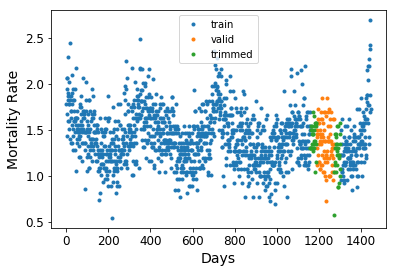

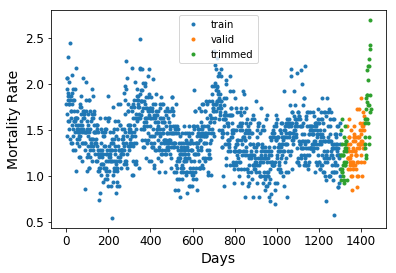

In [37]:
trimming=30
KFold=model_selection.KFold(n_splits=10)
i=0
for train_ndx,valid_ndx in KFold.split(X,y):
    fig=plt.figure()
    plt.xlabel('Days')
    plt.ylabel('Mortality Rate')
    trimmed=np.zeros(valid_ndx.shape,np.bool)
    trimmed[:trimming]=True
    trimmed[-trimming:]=True
    plt.plot(train_ndx,y[train_ndx],'.',label='train')
    plt.plot(valid_ndx[~trimmed],y[valid_ndx[~trimmed]],'.',label='valid')
    plt.plot(valid_ndx[trimmed],y[valid_ndx[trimmed]],'.',label='trimmed')
    plt.legend()
    plt.show()  
    savepdf(fig,'pis_split_k_{}'.format(i))
    i+=1

We will drop some starting and ending datapoints to create a more independent testing set.

In [38]:
KFold=model_selection.KFold(n_splits=10)
points_to_drop=10
scores=[]
for train_ndx,valid_ndx in KFold.split(X,y):
    valid_ndx_adjusted=valid_ndx[points_to_drop:-points_to_drop]
    pipe.fit(X[train_ndx],y[train_ndx])
    score=(metrics.mean_squared_error\
          (y[valid_ndx_adjusted],pipe.predict(X[valid_ndx_adjusted])))
    print(score)
    scores.append(score)
print('Average MSE of {0} with a standard error of {1}'.format(np.mean(scores),np.std(scores)/np.sqrt(KFold.n_splits)))

0.06314857880000001
0.06316353064
0.08461153799999999
0.044207981839999994
0.06772500863999999
0.08215728959999999
0.06734654776000001
0.07488263419354838
0.055966559435483856
0.048585421532258054
Average MSE of 0.06517950904412903 with a standard error of 0.003974180450480449


In [39]:
explained_variance=1-np.mean(scores)/metrics.mean_squared_error(np.mean(y).repeat(y.shape),y)
print(explained_variance)

0.20187334463918194


That got mildly worse, but not a major change.  Worst case can be pretty bad!

## Making an example where foreward prediction would give a drastically worse prediction than independent sets

In [40]:
n=150
x_adv=np.random.randn(n)
x_adv[75:]+=5

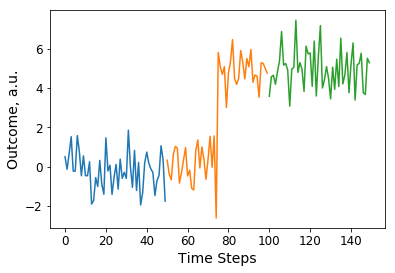

In [41]:
KFold=model_selection.KFold(n_splits=3,random_state=10,shuffle=False)
fig=plt.figure()
for train_ndx,valid_ndx in KFold.split(x_adv):
    plt.plot(valid_ndx,x_adv[valid_ndx])
plt.xlabel('Time Steps')
plt.ylabel('Outcome, a.u.')
plt.show()
savepdf(fig,'adv')

Think about this example.
What would happen when you try to predict the 2nd group of points from just the first group?
What would happen when you try to predict the 2nd group of points from the first and the third group of points?

## Making Autocorrelation Plots

Visualize the autocorrelation.

First, let's do this on the example that we've been working through above.

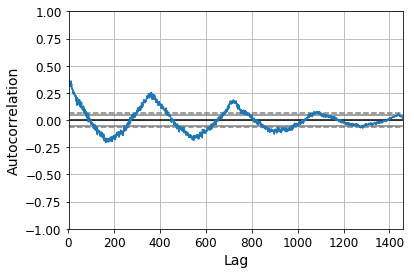

In [42]:
from pandas import Series
from pandas.plotting import autocorrelation_plot


# from pandas import Series
# from matplotlib import pyplot
# from statsmodels.graphics.tsaplots import plot_pacf
# series = Series.from_csv('daily-minimum-temperatures.csv', header=0)
# plot_pacf(series, lags=50)
# pyplot.show()

series = pd.Series(mortality_rates)
fig=plt.figure()
autocorrelation_plot(series)
plt.show()
savepdf(fig,'autocorr')

Let's look at atmospheric CO2 concentrations.  In particular, there is a famous dataset from Mauna Loa: https://www.esrl.noaa.gov/gmd/ccgg/trends/full.html

In [43]:
co2_df=pd.read_csv('./data/co2_weekly_mlo.txt',header=48,delim_whitespace=True)
co2_df[:5]

,yr,mon,day,decimal,ppm,"#days,",1_yr_ago,10_yr_ago,since_1800
0,1974,5,19,1974.3795,333.34,6,-999.99,-999.99,50.36
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.32,5,-999.99,-999.99,49.57
3,1974,6,9,1974.4370,332.18,7,-999.99,-999.99,49.63
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.07


In [44]:
# some quick_data_cleaning
# replace missing numbers with NaNs for clarity
missing=co2_df['ppm']<0
co2_df['ppm'].values[missing]=np.NaN

In [45]:
times=co2_df['decimal']
co2=co2_df['ppm']

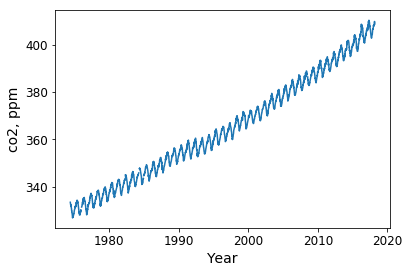

In [46]:
fig=plt.figure()
plt.plot(times,co2)
plt.xlabel('Year')
plt.ylabel('co2, ppm')
plt.show()
savepdf(fig,'c02')

We have some missing data, so we'll do a quick interpolation.  We'll come back to this.

In [47]:
from scipy.interpolate import interp1d
not_observed=np.isnan(co2)
interpolator=interp1d(times[~not_observed],co2[~not_observed],kind='cubic')
co2_interpolated=interpolator(times)

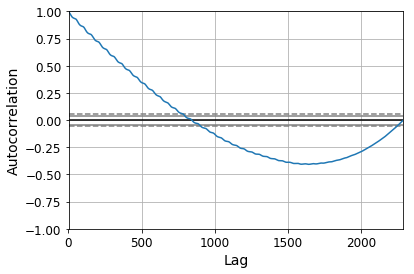

In [48]:
series = pd.Series(co2_interpolated)
fig=plt.figure()
autocorrelation_plot(series)
plt.show()
savepdf(fig,'autocorr')

Note that this isn't _clearly_ capturing the oscillatory trend.  Why is that?

Let's remove the linear trend.

In [49]:
lin_reg=linear_model.LinearRegression()
lin_reg.fit(times.values.reshape([-1,1]),co2_interpolated)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

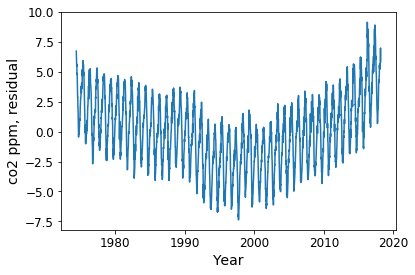

In [50]:
co2_interpolated_residual=co2_interpolated-lin_reg.predict(times.values.reshape([-1,1]))
fig=plt.figure()
plt.plot(times,co2_interpolated_residual)
plt.xlabel('Year')
plt.ylabel('co2 ppm, residual')
plt.show()

The pattern now pops out.

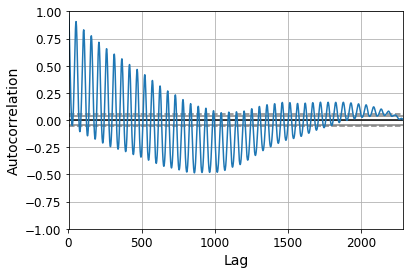

In [51]:
series = pd.Series(co2_interpolated_residual)
fig=plt.figure()
autocorrelation_plot(series)
plt.show()
savepdf(fig,'autocorr')